# Deloitte's Quantum Climate Challenge 2023

The challenge focuses on CO2 captuere in MOFs (Metal Organic Frameworks) ans is dvided in two principal tasks

## Task 1: Calculate the minimum of the potential energy surface of combinations gas molecules and metallic ions

### Task 1A: Build a quantum/quantum-hybrid algorithm. Run simulations and on real quantum devices

Pick at least one metallic ion from the list:
* __Mg2+ (2p6 - 10 e-)__
* Mn2+ (3d5 - 23 e-)
* Fe2+ (3d6 - 24 e-)
* Co2+ (3d7 - 25 e-)
* Ni2+ (3d8 - 26 e-)
* Cu2+ (3d9 - 27 e-)
* __Zn2+ (3d10 - 28 e-)__

And study the composite system with CO2 and another gas molecule:
* __CO2 (22 e-)__
* __H2O (10 e-)__
* __N2 (14e-)__


### Task 1B: Compare those results to classical simulations

This notebook Plots the results from the simulations with Qiskit, PySCF and real hardware results

### Imports and Helper Functions

In [1]:
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver #Algorithms

#Qiskit odds and ends
from qiskit.circuit.library import EfficientSU2, EvolvedOperatorAnsatz
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B
from qiskit.opflow import Z2Symmetries, X, Y, Z, I, PauliSumOp, Gradient, NaturalGradient
from qiskit import IBMQ, BasicAer, Aer, transpile
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.utils.mitigation import CompleteMeasFitter #Measurement error mitigatioin
from qiskit.tools.visualization import circuit_drawer
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.algorithms.minimum_eigensolvers import VQE, AdaptVQE, MinimumEigensolverResult
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.quantum_info import SparsePauliOp

#qiskit_nature
from qiskit_nature.second_q.drivers import PySCFDriver, MethodType
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.circuit.library import UCCSD, PUCCD, SUCCD, HartreeFock, CHC, VSCF
from qiskit_nature.second_q.operators.fermionic_op import FermionicOp
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer , FreezeCoreTransformer
from qiskit_nature.second_q.problems import ElectronicStructureProblem, EigenstateResult
from qiskit_nature.second_q.mappers import QubitConverter, ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.second_q.algorithms.ground_state_solvers.minimum_eigensolver_factories.vqe_ucc_factory import VQEUCCFactory
from qiskit_nature.second_q.algorithms.ground_state_solvers.minimum_eigensolver_factories.numpy_minimum_eigensolver_factory import NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.excited_states_solvers.eigensolver_factories.numpy_eigensolver_factory import NumPyEigensolverFactory
from qiskit_nature.second_q.algorithms.excited_states_solvers import QEOM, ExcitedStatesEigensolver

#Runtime
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit_ibm_runtime.options import Options, ResilienceOptions, SimulatorOptions, TranspilationOptions, ExecutionOptions

#PySCF
from functools import reduce
import scipy.linalg
from pyscf import scf
from pyscf import gto, dft
from pyscf import mcscf, fci
from functools import reduce
from pyscf.mcscf import avas, dmet_cas

#Python odds and ends
import matplotlib
import matplotlib.pyplot as plt
import pylab
import numpy as np
import os
import pyscf
from IPython.display import display, clear_output
import mapomatic as mm

from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

IBMQ.load_account()
provider = IBMQ.get_provider(group='deployed')
service = QiskitRuntimeService(channel='ibm_quantum')
#set Backends
#simulators
backend_stv = Aer.get_backend('aer_simulator_statevector')
#Real Devices
backend_nair= provider.get_backend('ibm_nairobi')
backend_manil = provider.get_backend('ibmq_manila')
backend_qsm_ibm=provider.get_backend('ibmq_qasm_simulator')
seed=42

#solvers
npme = NumPyMinimumEigensolver()
npe=NumPyEigensolver()

/var/folders/ts/54g0mcnn4glc0n7qph2hqb2c0000gn/T/ipykernel_80113/4269044919.py:61: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  IBMQ.load_account()
/var/folders/ts/54g0mcnn4glc0n7qph2hqb2c0000gn/T/ipykernel_80113/4269044919.py:61: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


Helper functions to save and read results

In [2]:
## Python program to store list to file using pickle module
import pickle

# write list to binary file
def write_list(a_list,filename):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')
        
def write_dict(a_dict,filename):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(a_dict, fp,protocol=pickle.HIGHEST_PROTOCOL)
        print('Done writing dict into a binary file')

# Read list to memory
def read(filename):
    # for reading also binary mode is important
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [3]:
import scipy.interpolate as interp
from scipy.optimize import minimize_scalar

def interpolate_pes(xdata,ydata):
    newx=xdata
    newy=ydata

    tck = interp.splrep(newx, newy, k=3)

    popt = lambda x: interp.splev(x, tck)
    popt_d = lambda x: interp.splev(x, tck, der=1)

    result = minimize_scalar(popt)
    assert result.success

    min_x = result.x
    min_val = result.fun
    x_left = min(newx)
    x_right = max(newy)
    
    my_dict={'popt':popt,
             'popt_d':popt_d,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right
    }

    return my_dict


## MG+H2O

We define a fitting function for this pair:

In [897]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=1.8,u0=-275)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 1

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 0.3
    morse_o_params['re'].max = 3
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [898]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Mg+H2O/simulations/ryrz_results')[1:10]
uccsd_results=read('Mg+H2O/simulations/uccsd_results')[1:10]
avqe_results=read('Mg+H2O/simulations/avqe_results')[1:10]
classic_results=read('Mg+H2O/simulations/classic_results')[1:10]
pyscf_energies=read('Mg+H2O/simulations/pyscf_energies')[1:10]
problems=read('Mg+H2O/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])
            

qiskit_engs={'ryrz':ryrz_energies[:1]+ryrz_energies[2:],'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

Read the PySCF simulation results

In [899]:
HF_engs=read('Mg+H2O/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Mg+H2O/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Mg+H2O/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [900]:
interpreted_results=read('Mg+H2O/VQE_results/interpreted_results')[1:10]
rdistances=np.arange(0.6,3.1,0.3)
montreal_energies=[]
for i in range(len(rdistances)):
            montreal_energies.append(interpreted_results[i].total_energies[0])

real_engs={'montreal':montreal_energies}

interpolate all the data

In [901]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(np.delete(distances,1),qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [902]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [903]:
real_interp={}

real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [904]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(np.delete(distances,1),qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [905]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [906]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

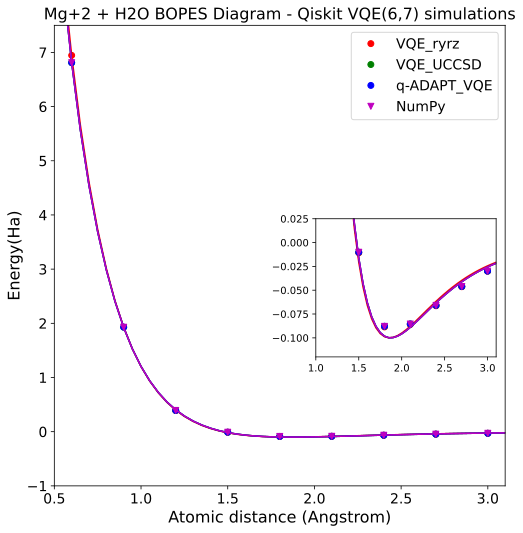

In [907]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(np.delete(distances,1),qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
ax1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
ax1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-')

ax1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
ax1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Mg+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(np.delete(distances,1),qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
axins1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
axins1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
axins1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.1,-0.12, 0.025
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = .5,3.1,-1, 7.5
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

#ax1.indicate_inset_zoom(axins1, edgecolor="black")

fig.savefig('Plots_bitmaps/Mg+H2O_VQE.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')


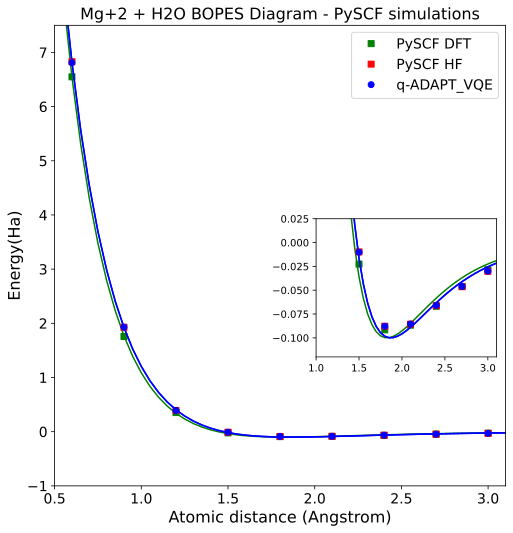

In [908]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
ax1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

ax1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
ax1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'b-')

ax1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - PySCF simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Mg+2 + H2O BOPES Diagram - PySCF simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
axins1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

axins1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
axins1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'b-')

axins1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')


xx1, xx2, yy1, yy2 = 1.0,3.1,-0.12, 0.025
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = .5,3.1,-1, 7.5
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

fig.savefig('Plots_bitmaps/Mg+H2O_PySCF.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')



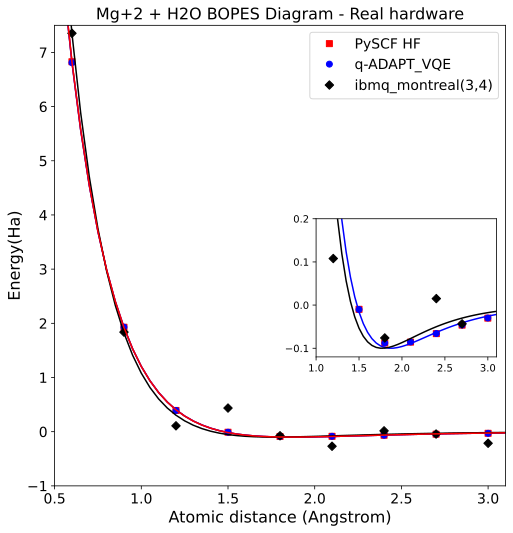

In [909]:
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
ax1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.plot(rdistances,real_engs['montreal']-real_fit['montreal']['result'].params['u0'].value,'kD',label='ibmq_montreal(3,4)')
ax1.plot(x, real_fit['montreal']['popt'](x)-real_fit['montreal']['result'].params['u0'].value, 'k-',)

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Mg+2 + H2O BOPES Diagram - Real hardware',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


axins1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
ax1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-')

axins1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

axins1.plot(rdistances,real_engs['montreal']-real_fit['montreal']['result'].params['u0'].value,'kD',label='ibmq_montreal(3,4)')
axins1.plot(x, real_fit['montreal']['popt'](x)-real_fit['montreal']['result'].params['u0'].value, 'k-',)

xx1, xx2, yy1, yy2 = 1.0,3.1,-0.12, 0.2
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = .5,3.1,-1, 7.5
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

fig.savefig('Plots_bitmaps/Mg+H2O_RHW.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

We can extract the minimun for both the numpy calculation and ibmq_montreal

In [767]:
min_x=real_fit['montreal']['result'].params['re'].value
min_x_err=real_fit['montreal']['result'].params['re'].stderr
print(f'Equilibrium distance from ibmq_montreal(3,4) data: {min_x} +/- {min_x_err}')
min_val=real_fit['montreal']['popt'](min_x)-real_fit['montreal']['result'].params['u0']
print(f'Binding Energy from ibmq_montreal(3,4) data: {min_val} Ha')

print('\n')

min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['avqe']['popt'](min_x)-qiskit_fit['avqe']['result'].params['u0']
print(f'Binding Energy from q-ADAPT_VQE(6,7) simulation: {min_val} Ha')

print('\n')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['classic']['popt'](min_x)-qiskit_fit['classic']['result'].params['u0']
print(f'Binding Energy from NumPy calculation: {min_val} Ha')

print('\n')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')
min_val=pyscf_fit['DFT']['popt'](min_x)-pyscf_fit['DFT']['result'].params['u0']
print(f'Binding Energy from PySCF DFT simulation: {min_val} Ha')

Equilibrium distance from ibmq_montreal(3,4) data: 1.7680159361458823 +/- 0.3264419494303973
Binding Energy from ibmq_montreal(3,4) data: -0.10000000001485887 Ha


Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.870221152660597 +/- 0.013804747283741963
Binding Energy from q-ADAPT_VQE(6,7) simulation: -0.10000000004862386 Ha


Equilibrium distance from NumPy calculation: 1.8698442264430752 +/- 0.012932481372847568
Binding Energy from NumPy calculation: -0.10000000008790266 Ha


Equilibrium distance from PySCF DFT simulation: 1.8252087677355893 +/- 0.015392573677799627
Binding Energy from PySCF DFT simulation: -0.10000000003236664 Ha


Finally we export this data as .csv files

In [ ]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
#df.index="Energy in Ha for"+distance
df.to_csv('MG+H2O/MG_H2O_data.csv', index=False, header=True)

In [ ]:
df

## Mg+CO2

We define a fitting function for this pair:

In [769]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=1.75,u0=-380)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 0.6
    morse_o_params['re'].max = 2.2
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [770]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Mg+CO2/simulations/ryrz_results')[1:10]
uccsd_results=read('Mg+CO2/simulations/uccsd_results')[1:10]
avqe_results=read('Mg+CO2/simulations/avqe_results')[1:10]
classic_results=read('Mg+CO2/simulations/classic_results')[1:10]
pyscf_energies=read('Mg+CO2/simulations/pyscf_energies')[1:10]
problems=read('Mg+CO2/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

Read the PySCF simulation results

In [771]:
HF_engs=read('Mg+CO2/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Mg+CO2/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Mg+CO2/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [772]:
# interpreted_results=read('Mg+CO2/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [773]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [774]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [775]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [776]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [777]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [778]:
pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])

In [779]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

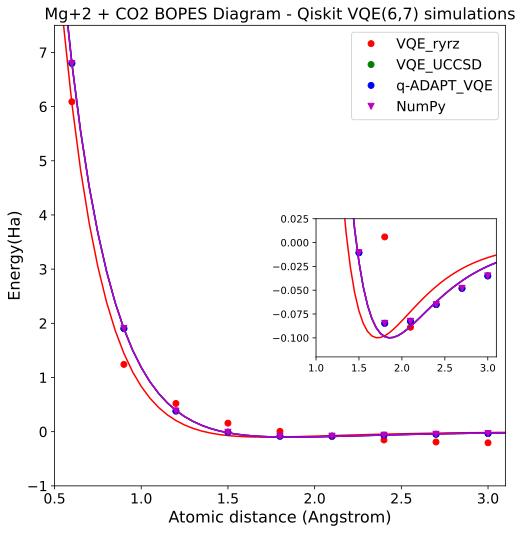

In [780]:
##QISKIT

distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
ax1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
ax1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-')

ax1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
ax1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Mg+2 + CO2 BOPES Diagram - Qiskit VQE(6,7) simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
axins1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
axins1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
axins1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.1,-0.12, 0.025
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = .5,3.1,-1, 7.5
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

fig.savefig('Plots_bitmaps/Mg+CO2_VQE.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

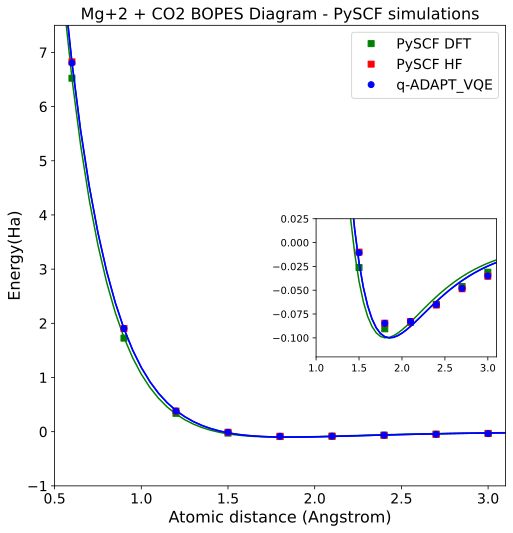

In [781]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
ax1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

ax1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
ax1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'b-')

ax1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - PySCF simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Mg+2 + CO2 BOPES Diagram - PySCF simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
axins1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

axins1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
axins1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')


xx1, xx2, yy1, yy2 = 1.0,3.1,-0.12, 0.025
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = .5,3.1,-1, 7.5
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)


fig.savefig('Plots_bitmaps/Mg+CO2_PySCF.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')


In [782]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [783]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['avqe']['popt'](min_x)-qiskit_fit['avqe']['result'].params['u0']
print(f'Binding Energy from q-ADAPT_VQE(6,7) simulation: {min_val} Ha')

print('\n')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['classic']['popt'](min_x)-qiskit_fit['classic']['result'].params['u0']
print(f'Binding Energy from NumPy calculation: {min_val} Ha')

print('\n')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')
min_val=pyscf_fit['DFT']['popt'](min_x)-pyscf_fit['DFT']['result'].params['u0']
print(f'Binding Energy from PySCF DFT simulation: {min_val} Ha')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.8596677737921827 +/- 0.015892107372860023
Binding Energy from q-ADAPT_VQE(6,7) simulation: -0.10000000003344667 Ha


Equilibrium distance from NumPy calculation: 1.8607407754689516 +/- 0.01633973973129443
Binding Energy from NumPy calculation: -0.10000000034727918 Ha


Equilibrium distance from PySCF DFT simulation: 1.8133322310200604 +/- 0.0185114913377812
Binding Energy from PySCF DFT simulation: -0.10000000002139586 Ha


Finally we export this data as .csv files

In [891]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
#df.index="Energy in Ha for"+distance
df.to_csv('MG+CO2/MG+CO2_data.csv', index=False, header=True)

In [892]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-379.713308,-380.905721,-379.621851,-379.618250,-379.630181,-266.819192,-379.033924,-379.630181
1,0.9,-384.617968,-385.703083,-384.543177,-384.519852,-384.520063,-272.334462,-383.882090,-384.520063
2,1.2,-386.137063,-387.091178,-386.065097,-386.042609,-386.042703,-274.064207,-384.602730,-386.042703
3,1.5,-386.527874,-387.455794,-386.456399,-386.434026,-386.434086,-273.736191,-384.965974,-386.434086
4,1.8,-386.601104,-387.520109,-386.531026,-386.508099,-386.508169,-274.248140,-385.117486,-386.508168
5,2.1,-386.597819,-387.513414,-386.529347,-386.505981,-386.506067,-274.441057,-385.212295,-386.506066
6,2.4,-386.579671,-387.494390,-386.511974,-386.488436,-386.488518,-274.157031,-385.276608,-386.488518
7,2.7,-386.562403,-387.475726,-386.494935,-386.471415,-386.471470,-274.215476,-385.314015,-386.471470
8,3.0,-386.549329,-387.460669,-386.481732,-386.458354,-386.458382,-274.385672,-385.328966,-386.458382


## Mg+N2

We write a function to fit the data

In [801]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=2,u0=-310)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 1
    morse_o_params['re'].max = 2.5
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [785]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Mg+N2/simulations/ryrz_results')[1:10]
uccsd_results=read('Mg+N2/simulations/uccsd_results')[1:10]
avqe_results=read('Mg+N2/simulations/avqe_results')[1:10]
classic_results=read('Mg+N2/simulations/classic_results')[1:10]
pyscf_energies=read('Mg+N2/simulations/pyscf_energies')[1:10]
problems=read('Mg+N2/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

Read the PySCF simulation results

In [786]:
HF_engs=read('Mg+N2/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Mg+N2/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Mg+N2/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [787]:
# interpreted_results=read('Mg+N2/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [788]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [789]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [790]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [798]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz']) #re=1.8
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [792]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [800]:
pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF']) #re=1.7

In [802]:
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT']) #re=2

In [795]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

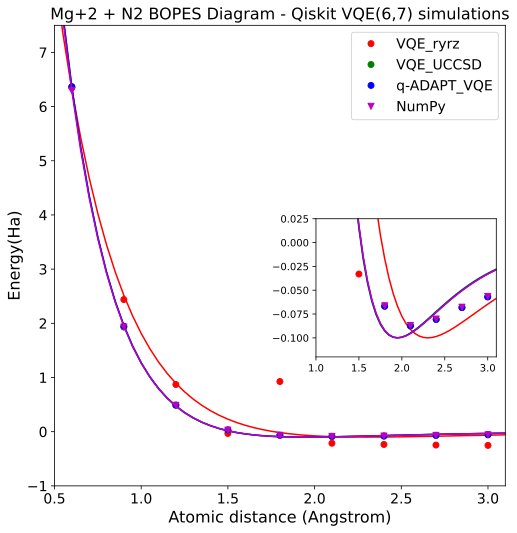

In [803]:
##QISKIT

distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
ax1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
ax1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-')

ax1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
ax1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Mg+2 + N2 BOPES Diagram - Qiskit VQE(6,7) simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
axins1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
axins1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
axins1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.1,-0.12, 0.025
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = .5,3.1,-1, 7.5
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

fig.savefig('Plots_bitmaps/Mg+N2_VQE.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

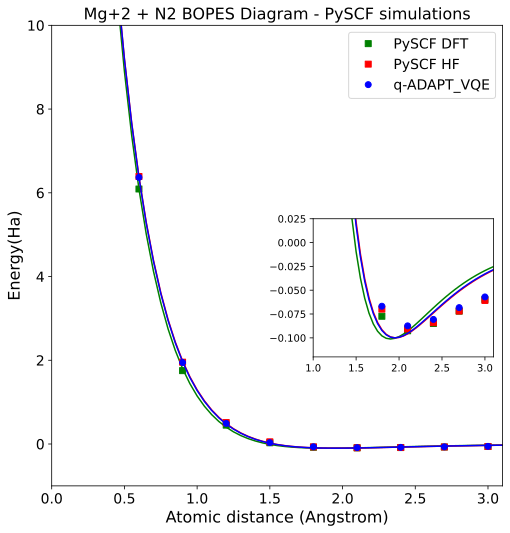

In [804]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
ax1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

ax1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
ax1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - PySCF simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Mg+2 + N2 BOPES Diagram - PySCF simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
axins1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

axins1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
axins1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-',label='avqe')

axins1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')


xx1, xx2, yy1, yy2 = 1.0,3.1,-0.12, 0.025
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = 0,3.1,-1, 10
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)



fig.savefig('Plots_bitmaps/Mg+N2_PySCF.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

In [1153]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [805]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['avqe']['popt'](min_x)-qiskit_fit['avqe']['result'].params['u0']
print(f'Binding Energy from q-ADAPT_VQE(6,7) simulation: {min_val} Ha')

print('\n')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['classic']['popt'](min_x)-qiskit_fit['classic']['result'].params['u0']
print(f'Binding Energy from NumPy calculation: {min_val} Ha')

print('\n')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')
min_val=pyscf_fit['DFT']['popt'](min_x)-pyscf_fit['DFT']['result'].params['u0']
print(f'Binding Energy from PySCF DFT simulation: {min_val} Ha')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.9508284831079614 +/- 0.037614863041827346
Binding Energy from q-ADAPT_VQE(6,7) simulation: -0.1000000000159389 Ha


Equilibrium distance from NumPy calculation: 1.9520104961597802 +/- 0.035912806261393995
Binding Energy from NumPy calculation: -0.10000000689535682 Ha


Equilibrium distance from PySCF DFT simulation: 1.898832966376383 +/- 0.06543173715174
Binding Energy from PySCF DFT simulation: -0.10119686359286106 Ha


Finally we export this data as .csv files

In [927]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Mg+N2/Mg+N2_data.csv', index=False, header=True)

In [928]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-301.473145,-302.281500,-301.335358,-301.348523,-301.421935,-266.819192,-300.975813,-301.352461
1,0.9,-305.900722,-306.619915,-305.769282,-305.769397,-305.785432,-272.334462,-304.887281,-305.785431
2,1.2,-307.353267,-307.921279,-307.212963,-307.223876,-307.229671,-274.064207,-306.454919,-307.229671
3,1.5,-307.812717,-308.342500,-307.673098,-307.683356,-307.686903,-273.736191,-307.358917,-307.686902
4,1.8,-307.933790,-308.449184,-307.793745,-307.782616,-307.782779,-274.248140,-306.400127,-307.782779
5,2.1,-307.954539,-308.464424,-307.814643,-307.803225,-307.803445,-274.441057,-307.539575,-307.803445
6,2.4,-307.947368,-308.456806,-307.808063,-307.796444,-307.796678,-274.157031,-307.562132,-307.796678
7,2.7,-307.934060,-308.443812,-307.795783,-307.784050,-307.784248,-274.215476,-307.573165,-307.784248
8,3.0,-307.921641,-308.431494,-307.784653,-307.772849,-307.772982,-274.385672,-307.579198,-307.772982


## Zn+H2O

We write a function to fit the data

In [806]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=2,u0=-310)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 1
    morse_o_params['re'].max = 2.5
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [807]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Zn+H2O/simulations/ryrz_results')[1:10]
uccsd_results=read('Zn+H2O/simulations/uccsd_results')[1:10]
avqe_results=read('Zn+H2O/simulations/avqe_results')[1:10]
classic_results=read('Zn+H2O/simulations/classic_results')[1:10]
pyscf_energies=read('Zn+H2O/simulations/pyscf_energies')[1:10]
problems=read('Zn+H2O/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies[:-2],'uccsd':uccsd_energies,'avqe':avqe_energies[:-1],'classic':classic_energies,'pyscf':pyscf_energies}

In [808]:
print(avqe_energies)

[-1841.5139410332881, -1850.1690719812573, -1852.1512646145893, -1852.610662587871, -1852.6902545992132, -1852.6836216847398, -1852.6601974619257, -1852.637654276882, -1852.334132162829]


Read the PySCF simulation results

In [809]:
HF_engs=read('Zn+H2O/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Zn+H2O/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Zn+H2O/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs[:-1],"CI":CI_engs}

Read the real hardware results

In [810]:
# interpreted_results=read('Zn+H2O/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [811]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances[:-2],qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances[:-1],qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [812]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances[:-1],pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [813]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [814]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances[:-2],qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances[:-1],qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [815]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances[:-1],pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [816]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

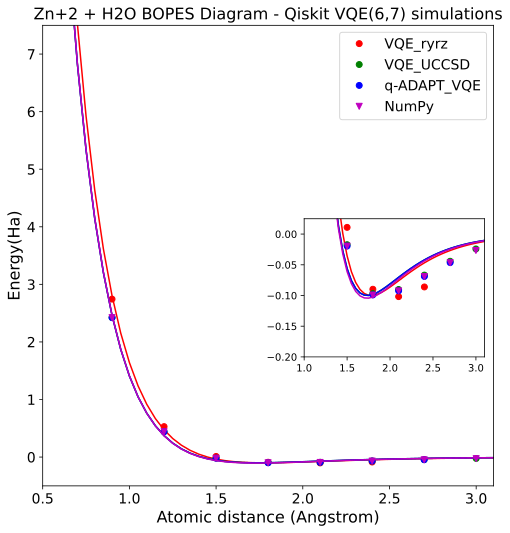

In [817]:
##QISKIT

distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances[:-2],qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
ax1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
ax1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-')

ax1.plot(distances[:-1],qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
ax1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Zn+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances[:-2],qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
axins1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
axins1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-',label='uccsd')

axins1.plot(distances[:-1],qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
axins1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.1,-0.2, 0.025
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = .5,3.1,-.5, 7.5
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

fig.savefig('Plots_bitmaps/Zn+H2O_VQE.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

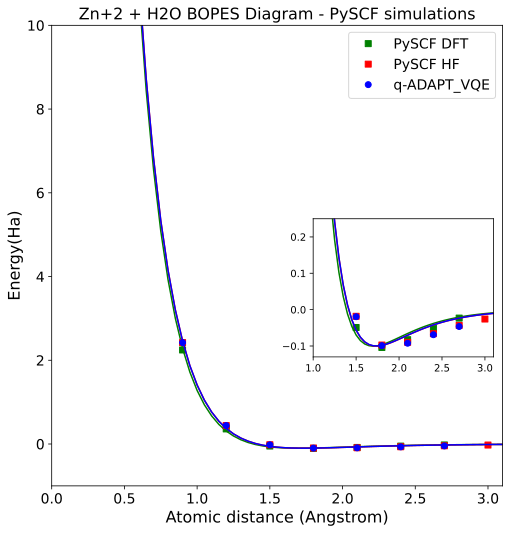

In [818]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances[:-1],pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
ax1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

ax1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
ax1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-')

ax1.plot(distances[:-1],qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - PySCF simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Zn+2 + H2O BOPES Diagram - PySCF simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances[:-1],pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
axins1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

axins1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
axins1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-',label='avqe')

axins1.plot(distances[:-1],qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')


xx1, xx2, yy1, yy2 = 1.0,3.1,-0.13, 0.25
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = 0,3.1,-1, 10
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)



fig.savefig('Plots_bitmaps/Zn+H2O_PySCF.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

In [819]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [820]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['avqe']['popt'](min_x)-qiskit_fit['avqe']['result'].params['u0']
print(f'Binding Energy from q-ADAPT_VQE(6,7) simulation: {min_val} Ha')

print('\n')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['classic']['popt'](min_x)-qiskit_fit['classic']['result'].params['u0']
print(f'Binding Energy from NumPy calculation: {min_val} Ha')

print('\n')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')
min_val=pyscf_fit['DFT']['popt'](min_x)-pyscf_fit['DFT']['result'].params['u0']
print(f'Binding Energy from PySCF DFT simulation: {min_val} Ha')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.7354359449856558 +/- 0.04242054535564605
Binding Energy from q-ADAPT_VQE(6,7) simulation: -0.10000000006039045 Ha


Equilibrium distance from NumPy calculation: 1.7316305780854795 +/- 0.04726366047873322
Binding Energy from NumPy calculation: -0.10445933486926151 Ha


Equilibrium distance from PySCF DFT simulation: 1.698647904690369 +/- 0.04181144768161699
Binding Energy from PySCF DFT simulation: -0.10048383508524239 Ha


Finally we export this data as .csv files

In [954]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Zn+H2O/Zn+H2O_data.csv', index=False, header=True)

In [955]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-1841.515512,-1840.943805,-1841.515832,-1841.513941,-1841.514919,-266.819192,-1840.055542,-1841.514919
1,0.9,-1850.179120,-1849.495639,-1850.179508,-1850.169072,-1850.169207,-272.334462,-1849.367678,-1850.169207
2,1.2,-1852.161078,-1851.381191,-1852.161130,-1852.151265,-1852.151362,-274.064207,-1851.582409,-1852.151362
3,1.5,-1852.613977,-1851.790049,-1852.619460,-1852.610663,-1852.610771,-273.736191,-1852.100636,-1852.610771
4,1.8,-1852.698222,-1851.844863,-1852.698525,-1852.690255,-1852.690346,-274.248140,-1852.201396,-1852.690346
5,2.1,-1852.691644,-1851.823562,-1852.691111,-1852.683622,-1852.683712,-274.441057,-1852.213400,-1852.683712
6,2.4,-1852.666377,-1851.791906,-1852.667333,-1852.660197,-1852.660286,-274.157031,-1852.197662,-1852.660286
7,2.7,-1852.642020,-1851.764144,-1852.644598,-1852.637654,-1852.637748,-274.215476,-1849.516321,-1852.637748
8,3.0,-1852.641973,-1852.626946,-1852.626946,-1852.334132,-1852.617833,-274.385672,-1852.592602,-1852.617686


## Zn+CO2

We write a function to fit the data

In [821]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=2,u0=-310)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 1
    morse_o_params['re'].max = 2.5
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [822]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Zn+CO2/simulations/ryrz_results')[1:10]
uccsd_results=read('Zn+CO2/simulations/uccsd_results')[1:10]
avqe_results=read('Zn+CO2/simulations/avqe_results')[1:10]
classic_results=read('Zn+CO2/simulations/classic_results')[1:10]
pyscf_energies=read('Zn+CO2/simulations/pyscf_energies')[1:10]
problems=read('Zn+CO2/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies[:-2],'uccsd':uccsd_energies,'avqe':avqe_energies[:-1],'classic':classic_energies,'pyscf':pyscf_energies}

In [823]:
print(avqe_energies)

[-1953.177480844024, -1961.8124301730732, -1963.7834467098212, -1964.2372108637915, -1964.3153417580643, -1964.3089355933018, -1964.2878742736093, -1964.2646999690446, -1963.556142840442]


Read the PySCF simulation results

In [824]:
HF_engs=read('Zn+CO2/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Zn+CO2/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Zn+CO2/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs[:-1],"CI":CI_engs}

Read the real hardware results

In [825]:
# interpreted_results=read('Zn+CO2/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [826]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances[:-2],qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances[:-1],qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [827]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances[:-1],pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [828]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [829]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances[:-2],qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances[:-1],qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [830]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances[:-1],pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [831]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

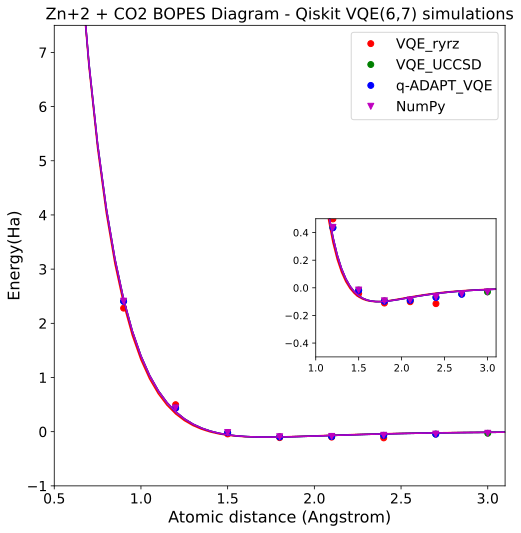

In [832]:
##QISKIT

distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances[:-2],qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
ax1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
ax1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-')

ax1.plot(distances[:-1],qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
ax1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Zn+2 + CO2 BOPES Diagram - Qiskit VQE(6,7) simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances[:-2],qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
axins1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
axins1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-',label='uccsd')

axins1.plot(distances[:-1],qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
axins1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.1,-0.5, 0.5
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = .5,3.1,-1, 7.5
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

fig.savefig('Plots_bitmaps/Zn+CO2_VQE.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

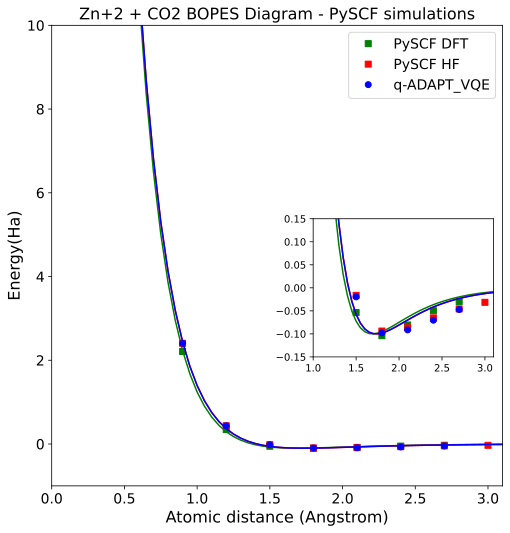

In [833]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances[:-1],pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
ax1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

ax1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
ax1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-')

ax1.plot(distances[:-1],qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - PySCF simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Zn+2 + CO2 BOPES Diagram - PySCF simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances[:-1],pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
axins1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

axins1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
axins1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-',label='avqe')

axins1.plot(distances[:-1],qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')


xx1, xx2, yy1, yy2 = 1.0,3.1,-0.15, 0.15
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = 0,3.1,-1, 10
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)



fig.savefig('Plots_bitmaps/Zn+CO2_PySCF.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

In [834]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [835]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['avqe']['popt'](min_x)-qiskit_fit['avqe']['result'].params['u0']
print(f'Binding Energy from q-ADAPT_VQE(6,7) simulation: {min_val} Ha')

print('\n')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['classic']['popt'](min_x)-qiskit_fit['classic']['result'].params['u0']
print(f'Binding Energy from NumPy calculation: {min_val} Ha')

print('\n')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')
min_val=pyscf_fit['DFT']['popt'](min_x)-pyscf_fit['DFT']['result'].params['u0']
print(f'Binding Energy from PySCF DFT simulation: {min_val} Ha')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.7324853954504191 +/- 0.05785896580449087
Binding Energy from q-ADAPT_VQE(6,7) simulation: -0.10000000004220055 Ha


Equilibrium distance from NumPy calculation: 1.7336068363789383 +/- 0.053167796928673475
Binding Energy from NumPy calculation: -0.10000000001355147 Ha


Equilibrium distance from PySCF DFT simulation: 1.6884000108216484 +/- 0.041059699522663466
Binding Energy from PySCF DFT simulation: -0.10000000002878551 Ha


Finally we export this data as .csv files

In [1269]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Zn+CO2/Zn+CO2_data.csv', index=False, header=True)

In [1270]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-1953.328354,-1953.161517,-1953.199054,-1953.177481,-1953.180211,-266.819192,-1952.694355,-1953.180211
1,0.9,-1961.957938,-1961.682518,-1961.843990,-1961.812430,-1961.813001,-272.334462,-1961.482131,-1961.813001
2,1.2,-1963.922971,-1963.546852,-1963.813270,-1963.783447,-1963.783924,-274.064207,-1963.263639,-1963.783924
3,1.5,-1964.379958,-1963.944830,-1964.264902,-1964.237211,-1964.237456,-273.736191,-1963.803868,-1964.237455
4,1.8,-1964.460590,-1963.995065,-1964.342359,-1964.315342,-1964.315542,-274.248140,-1963.872433,-1964.315542
5,2.1,-1964.451853,-1963.971852,-1964.335356,-1964.308936,-1964.309212,-274.441057,-1963.862826,-1964.309212
6,2.4,-1964.428047,-1963.940853,-1964.313856,-1964.287874,-1964.288095,-274.157031,-1963.876759,-1964.288094
7,2.7,-1964.358684,-1963.921025,-1964.294374,-1964.264700,-1964.265511,-274.215476,-1964.264934,-1964.265511
8,3.0,-1964.301702,-1964.280056,-1964.280056,-1963.556143,-1964.251321,-274.385672,-1964.167544,-1964.250832


## Zn+N2

We write a function to fit the data

In [836]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=1.5,u0=-1885)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = .3
    morse_o_params['re'].max = 3.0
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [837]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Zn+N2/simulations/ryrz_results')[1:10]
uccsd_results=read('Zn+N2/simulations/uccsd_results')[1:10]
avqe_results=read('Zn+N2/simulations/avqe_results')[1:10]
classic_results=read('Zn+N2/simulations/classic_results')[1:10]
pyscf_energies=read('Zn+N2/simulations/pyscf_energies')[1:10]
problems=read('Zn+N2/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

In [838]:
print(avqe_energies)

[-1875.604342542135, -1883.27655272432, -1885.0259402291501, -1885.4952292068135, -1885.6031593484893, -1885.613499134299, -1885.5998014566899, -1885.5828616187448, -1885.5683409901828]


Read the PySCF simulation results

In [839]:
HF_engs=read('Zn+N2/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Zn+N2/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Zn+N2/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [840]:
# interpreted_results=read('Zn+N2/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [841]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [842]:
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])

In [843]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [844]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [845]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [846]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [847]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

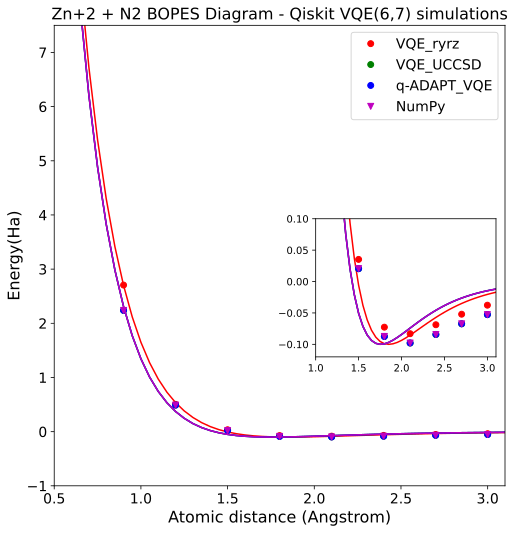

In [848]:
##QISKIT

distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
ax1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
ax1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-')

ax1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
ax1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Zn+2 + N2 BOPES Diagram - Qiskit VQE(6,7) simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
axins1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
axins1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
axins1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.1,-0.12, 0.1
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = .5,3.1,-1, 7.5
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

fig.savefig('Plots_bitmaps/Zn+N2_VQE.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')


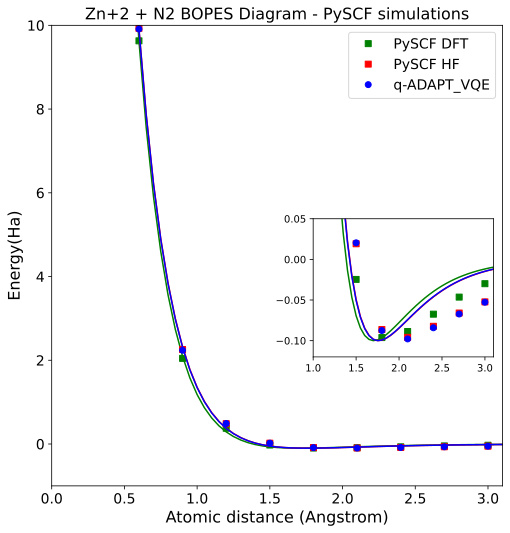

In [849]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
ax1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

ax1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
ax1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - PySCF simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Zn+2 + N2 BOPES Diagram - PySCF simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
axins1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

axins1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
axins1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-',label='avqe')

axins1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')


xx1, xx2, yy1, yy2 = 1.0,3.1,-0.12, 0.05
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = 0,3.1,-1, 10
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)



fig.savefig('Plots_bitmaps/Zn+N2_PySCF.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

In [532]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [850]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['avqe']['popt'](min_x)-qiskit_fit['avqe']['result'].params['u0']
print(f'Binding Energy from q-ADAPT_VQE(6,7) simulation: {min_val} Ha')

print('\n')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['classic']['popt'](min_x)-qiskit_fit['classic']['result'].params['u0']
print(f'Binding Energy from NumPy calculation: {min_val} Ha')

print('\n')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')
min_val=pyscf_fit['DFT']['popt'](min_x)-pyscf_fit['DFT']['result'].params['u0']
print(f'Binding Energy from PySCF DFT simulation: {min_val} Ha')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.7570283475830708 +/- 0.08748709169653354
Binding Energy from q-ADAPT_VQE(6,7) simulation: -0.10000000002878551 Ha


Equilibrium distance from NumPy calculation: 1.7569303169392976 +/- 0.07685459050007111
Binding Energy from NumPy calculation: -0.10000000000854925 Ha


Equilibrium distance from PySCF DFT simulation: 1.7039825873834453 +/- 0.049589659933955504
Binding Energy from PySCF DFT simulation: -0.10000000000218279 Ha


Finally we export this data as .csv files

In [1020]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Zn+N2/Zn+N2_data.csv', index=False, header=True)

In [1021]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-1875.737739,-1875.218214,-1875.603628,-1875.604343,-1875.608927,-266.819192,-1875.150208,-1875.608927
1,0.9,-1883.452837,-1882.802587,-1883.276229,-1883.276553,-1883.278310,-272.334462,-1882.824726,-1883.278310
2,1.2,-1885.211194,-1884.471916,-1885.047845,-1885.025940,-1885.026425,-274.064207,-1885.026002,-1885.026425
3,1.5,-1885.664445,-1884.871963,-1885.513434,-1885.495229,-1885.495543,-273.736191,-1885.495246,-1885.495542
4,1.8,-1885.768410,-1884.943562,-1885.619010,-1885.603159,-1885.603505,-274.248140,-1885.603191,-1885.603505
5,2.1,-1885.784252,-1884.936068,-1885.628619,-1885.613499,-1885.614070,-274.441057,-1885.613576,-1885.614070
6,2.4,-1885.772280,-1884.914740,-1885.615008,-1885.599801,-1885.600507,-274.157031,-1885.599317,-1885.600507
7,2.7,-1885.752671,-1884.893728,-1885.598642,-1885.582862,-1885.583481,-274.215476,-1885.582541,-1885.583480
8,3.0,-1885.733453,-1884.877220,-1885.584968,-1885.568341,-1885.568809,-274.385672,-1885.568172,-1885.568809


## Cu+H2O

We write a function to fit the data

In [851]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=2,u0=-1800)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 1
    morse_o_params['re'].max = 2.5
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [852]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Cu+H2O/simulations/ryrz_results')[1:10]
uccsd_results=read('Cu+H2O/simulations/uccsd_results')[1:10]
avqe_results=read('Cu+H2O/simulations/avqe_results')[1:10]
classic_results=read('Cu+H2O/simulations/classic_results')[1:10]
pyscf_energies=read('Cu+H2O/simulations/pyscf_energies')[1:10]
problems=read('Cu+H2O/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies,'classic':classic_energies,'pyscf':pyscf_energies}

In [853]:
print(avqe_energies)

[-1703.2604796405092, -1711.463143842524, -1713.3237101802292, -1713.7845972128628, -1713.8481731687289, -1713.843902946498, -1713.7852711906262, -1713.6391578351588, -1713.70374481601]


Read the PySCF simulation results

In [854]:
HF_engs=read('Cu+H2O/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Cu+H2O/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Cu+H2O/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [855]:
# interpreted_results=read('Cu+H2O/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [856]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances,qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [857]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [858]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [859]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances,qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [860]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [861]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

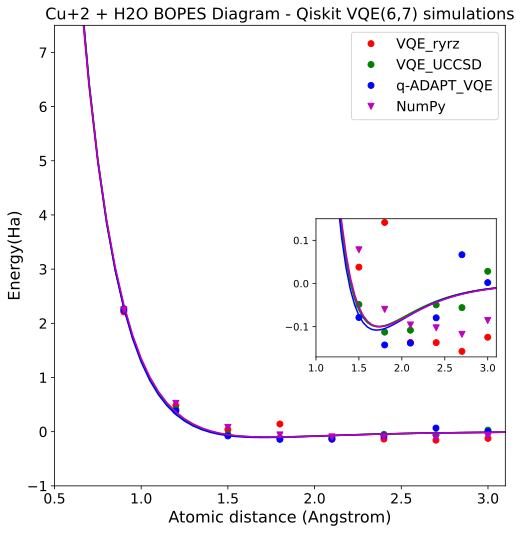

In [862]:
##QISKIT

distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
ax1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
ax1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-')

ax1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
ax1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Cu+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
axins1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
axins1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-',label='uccsd')

axins1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
axins1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.1,-0.17, 0.15
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = .5,3.1,-1, 7.5
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

fig.savefig('Plots_bitmaps/Cu+H2O_VQE.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

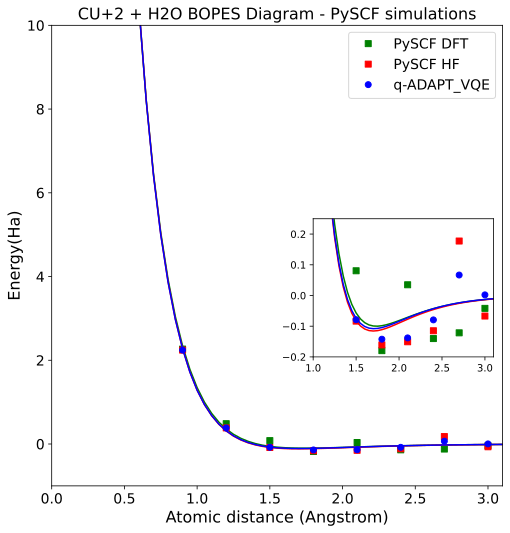

In [863]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
ax1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

ax1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
ax1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - PySCF simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('CU+2 + H2O BOPES Diagram - PySCF simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
axins1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

axins1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
axins1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-',label='avqe')

axins1.plot(distances,qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')


xx1, xx2, yy1, yy2 = 1.0,3.1,-0.2, 0.25
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = 0,3.1,-1, 10
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)



fig.savefig('Plots_bitmaps/Cu+H2O_PySCF.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

In [864]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [865]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['avqe']['popt'](min_x)-qiskit_fit['avqe']['result'].params['u0']
print(f'Binding Energy from q-ADAPT_VQE(6,7) simulation: {min_val} Ha')

print('\n')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['classic']['popt'](min_x)-qiskit_fit['classic']['result'].params['u0']
print(f'Binding Energy from NumPy calculation: {min_val} Ha')

print('\n')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')
min_val=pyscf_fit['DFT']['popt'](min_x)-pyscf_fit['DFT']['result'].params['u0']
print(f'Binding Energy from PySCF DFT simulation: {min_val} Ha')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.7061123654248052 +/- 0.06462687894349542
Binding Energy from q-ADAPT_VQE(6,7) simulation: -0.10810775201821343 Ha


Equilibrium distance from NumPy calculation: 1.744784522938982 +/- 0.08281938601148665
Binding Energy from NumPy calculation: -0.1000000000003638 Ha


Equilibrium distance from PySCF DFT simulation: 1.737117388269911 +/- 0.16334899696344263
Binding Energy from PySCF DFT simulation: -0.10000000000172804 Ha


Finally we export this data as .csv files

In [1303]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Cu+H2O/Cu+H2O_data.csv', index=False, header=True)

In [1304]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-1703.320480,-1703.271616,-1703.269644,-1703.260480,-1704.091083,-266.819192,-1704.090883,-1703.261812
1,0.9,-1711.484010,-1711.435233,-1711.477245,-1711.463144,-1712.145872,-272.334462,-1712.144713,-1711.464320
2,1.2,-1713.342295,-1713.216911,-1713.336798,-1713.323710,-1713.871924,-274.064207,-1713.871924,-1713.323839
3,1.5,-1713.801597,-1713.621026,-1713.803621,-1713.784597,-1714.316884,-273.736191,-1714.316623,-1713.784706
4,1.8,-1713.894923,-1713.881076,-1713.881076,-1713.848173,-1714.454893,-274.248140,-1714.213099,-1713.848766
5,2.1,-1713.853831,-1713.666675,-1713.870900,-1713.843903,-1714.491027,-274.441057,-1714.491025,-1713.844308
6,2.4,-1713.856244,-1713.841771,-1713.834979,-1713.785271,-1714.497570,-274.157031,-1714.491421,-1713.785568
7,2.7,-1713.837892,-1713.823119,-1713.542689,-1713.639158,-1714.512718,-274.215476,-1714.511729,-1713.791882
8,3.0,-1713.758468,-1713.743472,-1713.787086,-1713.703745,-1714.480723,-274.385672,-1714.478940,-1713.707829


## Cu+CO2

In [866]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=.1, a=1, re=2,u0=-1800)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 1
    morse_o_params['re'].max = 2.5
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [867]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Cu+Co2/simulations/ryrz_results')[1:10]
uccsd_results=read('Cu+Co2/simulations/uccsd_results')[1:10]
avqe_results=read('Cu+Co2/simulations/avqe_results')[1:10]
classic_results=read('Cu+Co2/simulations/classic_results')[1:10]
pyscf_energies=read('Cu+CO2/simulations/pyscf_energies')[1:10]
problems=read('Cu+Co2/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies[:-1],'classic':classic_energies,'pyscf':pyscf_energies}

In [868]:
print(avqe_energies)

[-1814.9272867277334, -1823.0915385800604, -1824.9182307648755, -1825.3775394901722, -1825.4475357141935, -1825.4327570738346, -1825.4092929426924, -1825.372046198568, -1823.193357723379]


Read the PySCF simulation results

In [869]:
HF_engs=read('Cu+Co2/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Cu+Co2/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Cu+Co2/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [870]:
# interpreted_results=read('Cu+Co2/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [871]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(distances[:-1],qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [872]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [873]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [874]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'])
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'])
qiskit_fit['avqe']=morse_fit(distances[:-1],qiskit_engs['avqe'])
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'])
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'])

In [875]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'])
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'])
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'])

In [876]:
real_fit={}

real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

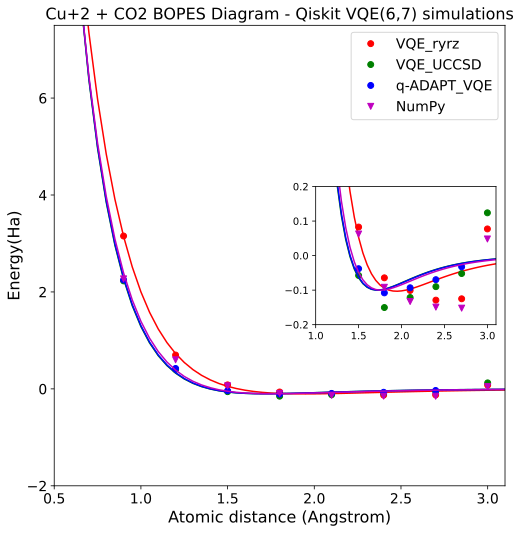

In [877]:
##QISKIT

distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
ax1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
ax1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-')

ax1.plot(distances[:-1],qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
ax1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Cu+2 + CO2 BOPES Diagram - Qiskit VQE(6,7) simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)



axins2 = ax1.inset_axes([0.58, 0.35, 0.4, 0.3])
axins2.plot(distances,qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
axins2.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-',label='ryrz')

axins2.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
axins2.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-',label='uccsd')

axins2.plot(distances[:-1],qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins2.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-',label='avqe')

axins2.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
axins2.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.1,-0.2, 0.2
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)


x1, x2, y1, y2 = .5,3.1,-2, 7.5
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

fig.savefig('Plots_bitmaps/Cu+CO2_VQE.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

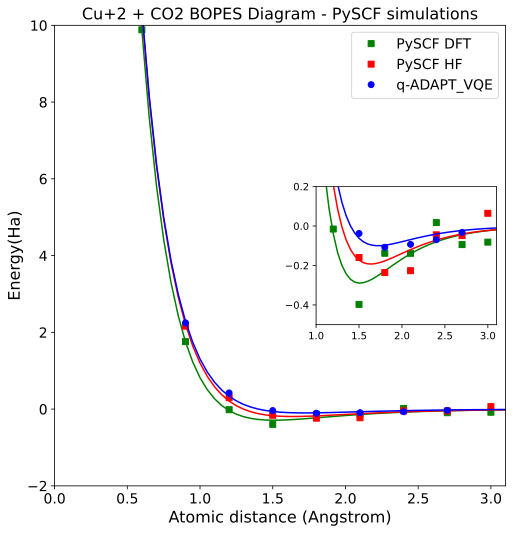

In [878]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
ax1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

ax1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
ax1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-')

ax1.plot(distances[:-1],qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - PySCF simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Cu+2 + CO2 BOPES Diagram - PySCF simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)



axins2 = ax1.inset_axes([0.58, 0.35, 0.4, 0.3])
axins2.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
axins2.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

axins2.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
axins2.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-',label='avqe')

axins2.plot(distances[:-1],qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins2.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

xx1, xx2, yy1, yy2 = 1.0,3.1,-0.5, 0.2
axins2.set_xlim(xx1, xx2)
axins2.set_ylim(yy1, yy2)


x1, x2, y1, y2 = 0,3.1,-2, 10
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)



fig.savefig('Plots_bitmaps/Cu+CO2_PySCF.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

In [581]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

Finally we export this data as .csv files

In [879]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['avqe']['popt'](min_x)-qiskit_fit['avqe']['result'].params['u0']
print(f'Binding Energy from q-ADAPT_VQE(6,7) simulation: {min_val} Ha')

print('\n')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['classic']['popt'](min_x)-qiskit_fit['classic']['result'].params['u0']
print(f'Binding Energy from NumPy calculation: {min_val} Ha')

print('\n')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')
min_val=pyscf_fit['DFT']['popt'](min_x)-pyscf_fit['DFT']['result'].params['u0']
print(f'Binding Energy from PySCF DFT simulation: {min_val} Ha')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.7222618678569264 +/- 0.06770905568731966
Binding Energy from q-ADAPT_VQE(6,7) simulation: -0.10000000013997123 Ha


Equilibrium distance from NumPy calculation: 1.7588430873755139 +/- 0.16398593982858276
Binding Energy from NumPy calculation: -0.10000000000104592 Ha


Equilibrium distance from PySCF DFT simulation: 1.508568708921952 +/- 0.029134812550463476
Binding Energy from PySCF DFT simulation: -0.2895250421779565 Ha


In [ ]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Cu+N2/Cu+N2_data.csv', index=False, header=True)

In [1321]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-1815.090704,-1815.493235,-1814.955484,-1814.927287,-1815.687981,-266.819192,-1815.003346,-1814.932397
1,0.9,-1823.257638,-1823.618611,-1823.128268,-1823.091539,-1823.740688,-272.334462,-1822.876270,-1823.092127
2,1.2,-1825.088236,-1825.391727,-1824.992292,-1824.918231,-1825.409864,-274.064207,-1825.331689,-1824.919127
3,1.5,-1825.523506,-1825.773683,-1825.447956,-1825.377539,-1825.947402,-273.736191,-1825.947400,-1825.377741
4,1.8,-1825.538070,-1825.514331,-1825.524349,-1825.447536,-1826.101603,-274.248140,-1826.094402,-1825.470555
5,2.1,-1825.537762,-1825.514754,-1825.514754,-1825.432757,-1826.142788,-274.441057,-1826.130919,-1825.441537
6,2.4,-1825.401102,-1825.359205,-1825.333107,-1825.409293,-1826.159016,-274.157031,-1826.159004,-1825.410151
7,2.7,-1825.492411,-1825.470559,-1825.336974,-1825.372046,-1826.162002,-274.215476,-1826.155115,-1825.372129
8,3.0,-1825.479742,-1825.458080,-1825.223814,-1823.193358,-1825.961735,-274.385672,-1825.952823,-1825.196337


## Cu+N2

In [880]:
import lmfit
from scipy.optimize import minimize_scalar

def morse(r, D, a, re,u0):
          
    return D*((1 - np.exp(-a*(r - re)))**2 -1)+u0

def morse_fit(x,y,DD,aa,rere,u0u0):
    xdata=x
    ydata=y
    morse_o_model = lmfit.Model(morse)
    morse_o_params = morse_o_model.make_params(D=DD, a=aa, re=rere,u0=u0u0)


    morse_o_params['D'].min = .1
    morse_o_params['D'].max = 100

    morse_o_params['a'].min = .1
    morse_o_params['a'].max = 3

    morse_o_params['re'].min = 1
    morse_o_params['re'].max = 2.5
    

    morse_o_result = morse_o_model.fit(ydata, morse_o_params, r=xdata)

    morse_o_popt = np.array(morse_o_result.params)
    
    popt=lambda x: morse(x, morse_o_popt[0], morse_o_popt[1], morse_o_popt[2],morse_o_popt[3])
    result = minimize_scalar(popt)
    
    min_x = result.x
    min_val = result.fun
    x_left = min(xdata)
    x_right = max(ydata)
    
    my_dict={'popt':popt,
             'min_x':min_x,
             'min_val':min_val,
             'x_left':x_left,
             'x_right':x_right,
             'params':morse_o_popt,
             'result':morse_o_result
    }
    
    return my_dict


Read the Qiskit simulation results

In [881]:
distances = np.arange(0.6, 3.1, 0.3)
ryrz_results=read('Cu+N2/simulations/ryrz_results')[1:10]
uccsd_results=read('Cu+N2/simulations/uccsd_results')[1:10]
avqe_results=read('Cu+N2/simulations/avqe_results')[1:10]
classic_results=read('Cu+N2/simulations/classic_results')[1:10]
pyscf_energies=read('Cu+N2/simulations/pyscf_energies')[1:10]
problems=read('Cu+N2/simulations/avqe_problems')[1:10]

avqe_energies=[]
ryrz_energies=[]
uccsd_energies=[]
classic_energies=[]
for i in range(len(distances)):
            avqe_energies.append(avqe_results[i].total_energies[0])
            ryrz_energies.append(problems[i].interpret(ryrz_results[i]).total_energies[0])
            uccsd_energies.append(problems[i].interpret(uccsd_results[i]).total_energies[0])
            classic_energies.append(classic_results[i].total_energies[0])

qiskit_engs={'ryrz':ryrz_energies,'uccsd':uccsd_energies,'avqe':avqe_energies[:7]+avqe_energies[8:],'classic':classic_energies,'pyscf':pyscf_energies}

In [882]:
print(avqe_energies)

[-1737.398768454305, -1744.6593893718914, -1746.2221349663726, -1746.6618731720323, -1746.7738568474024, -1746.7702964549471, -1746.7475735824664, -1746.380484340334, -1746.6913496662196]


Read the PySCF simulation results

In [883]:
HF_engs=read('Cu+N2/simulations/pyscf_HF_results')[1:10]
DFT_engs=read('Cu+N2/simulations/pyscf_DFT_results')[1:10]
CI_engs=read('Cu+N2/simulations/pyscf_CASCI_results')[1:10]
pyscf_engs={'HF':HF_engs,"DFT":DFT_engs,"CI":CI_engs}

Read the real hardware results

In [884]:
# interpreted_results=read('Cu+N2/VQE_results/interpreted_results')
# rdistances=np.arange(0.3,3.5,0.3)
# montreal_energies=[]
# for i in range(len(rdistances)):
#             montreal_energies.append(interpreted_results[i].total_energies[0])

# real_engs={'montreal':montreal_energies}

interpolate all the data

In [885]:
qiskit_interp={}

qiskit_interp['ryrz']=interpolate_pes(distances,qiskit_engs['ryrz'])
qiskit_interp['uccsd']=interpolate_pes(distances,qiskit_engs['uccsd'])
qiskit_interp['avqe']=interpolate_pes(np.delete(distances,7),qiskit_engs['avqe'])
qiskit_interp['classic']=interpolate_pes(distances,qiskit_engs['classic'])
qiskit_interp['pyscf']=interpolate_pes(distances,qiskit_engs['pyscf'])

In [886]:
pyscf_interp={}

pyscf_interp['HF']=interpolate_pes(distances,pyscf_engs['HF'])
pyscf_interp['DFT']=interpolate_pes(distances,pyscf_engs['DFT'])
pyscf_interp['CI']=interpolate_pes(distances,pyscf_engs['CI'])

In [887]:
# real_interp={}

# real_interp['montreal']=interpolate_pes(rdistances,real_engs['montreal'])

fit all data

In [888]:
qiskit_fit={}

qiskit_fit['ryrz']=morse_fit(distances,qiskit_engs['ryrz'],.1,1,2,-1800)
qiskit_fit['uccsd']=morse_fit(distances,qiskit_engs['uccsd'],.1,1,2,-1800)
qiskit_fit['avqe']=morse_fit(np.delete(distances,7),qiskit_engs['avqe'],.15,1,2,-1800)
qiskit_fit['classic']=morse_fit(distances,qiskit_engs['classic'],.1,1,2,-1800)
qiskit_fit['pyscf']=morse_fit(distances,qiskit_engs['pyscf'],.1,1,2,-1800)

In [889]:
pyscf_fit={}

pyscf_fit['HF']=morse_fit(distances,pyscf_engs['HF'],.1,1,1.8,-1800)
pyscf_fit['DFT']=morse_fit(distances,pyscf_engs['DFT'],.08,1,1.8,-1800)
pyscf_fit['CI']=morse_fit(distances,pyscf_engs['CI'],.1,1,1.8,-1800)

In [890]:
# real_fit={}

# real_fit['montreal']=morse_fit(rdistances,real_engs['montreal'])

Plot the data

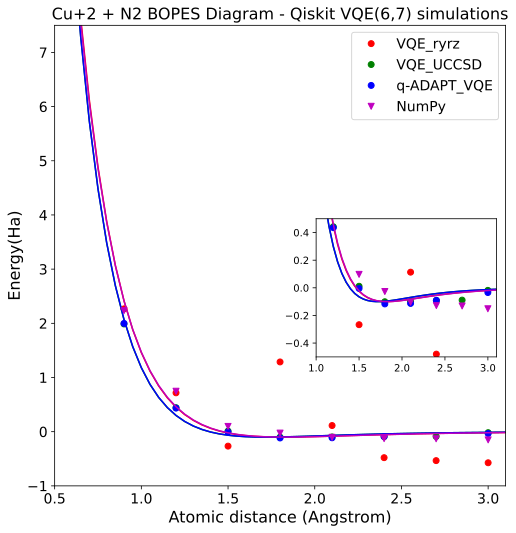

In [894]:
##QISKIT

distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)
ax1.plot(distances,qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
ax1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-')

ax1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
ax1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-')

ax1.plot(np.delete(distances,7),qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
ax1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Qiskit VQE(6,7) simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Cu+2 + N2 BOPES Diagram - Qiskit VQE(6,7) simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,qiskit_engs['ryrz']-qiskit_fit['ryrz']['result'].params['u0'].value,'ro',label='VQE_ryrz')
axins1.plot(x, qiskit_fit['ryrz']['popt'](x)-qiskit_fit['ryrz']['result'].params['u0'].value, 'r-',label='ryrz')

axins1.plot(distances,qiskit_engs['uccsd']-qiskit_fit['uccsd']['result'].params['u0'].value,'go',label='VQE_UCCSD')
axins1.plot(x, qiskit_fit['uccsd']['popt'](x)-qiskit_fit['uccsd']['result'].params['u0'].value, 'g-',label='uccsd')

axins1.plot(np.delete(distances,7),qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-',label='avqe')

axins1.plot(distances,qiskit_engs['classic']-qiskit_fit['classic']['result'].params['u0'].value,'mv',label='NumPy')
axins1.plot(x, qiskit_fit['classic']['popt'](x)-qiskit_fit['classic']['result'].params['u0'].value, 'm-',label='classic')

xx1, xx2, yy1, yy2 = 1.0,3.1,-0.5, 0.5
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = .5,3.1,-1, 7.5
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)

fig.savefig('Plots_bitmaps/Cu+N2_VQE.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

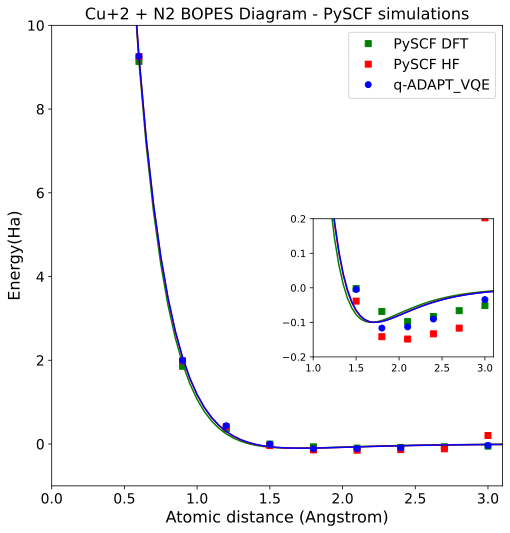

In [893]:
##QISKIT
distances = np.arange(0.6, 3.1, 0.3)
fig, ax1=plt.subplots(1,1,figsize=(7,7))
fig.tight_layout()

#####ax1

x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


ax1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
ax1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

ax1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
ax1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-')

ax1.plot(np.delete(distances,7),qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
ax1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')

ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - PySCF simulations')
ax1.set_xlabel('Atomic distance (Angstrom)',fontsize=16)
ax1.set_ylabel('Energy(Ha)',fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.tick_params(axis='y',labelsize=14)
ax1.set_title('Cu+2 + N2 BOPES Diagram - PySCF simulations',fontsize=16)
ax1.legend(loc='upper right',fontsize=14)


axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])
axins1.plot(distances,pyscf_engs['DFT']-pyscf_fit['DFT']['result'].params['u0'].value,'gs',label='PySCF DFT')
axins1.plot(x, pyscf_fit['DFT']['popt'](x)-pyscf_fit['DFT']['result'].params['u0'].value, 'g-')

axins1.plot(distances,pyscf_engs['HF']-pyscf_fit['HF']['result'].params['u0'].value,'rs',label='PySCF HF')
axins1.plot(x, pyscf_fit['HF']['popt'](x)-pyscf_fit['HF']['result'].params['u0'].value, 'r-',label='avqe')

axins1.plot(np.delete(distances,7),qiskit_engs['avqe']-qiskit_fit['avqe']['result'].params['u0'].value,'bo',label='q-ADAPT_VQE')
axins1.plot(x, qiskit_fit['avqe']['popt'](x)-qiskit_fit['avqe']['result'].params['u0'].value, 'b-')


xx1, xx2, yy1, yy2 = 1.0,3.1,-0.18, 0.025
xx1, xx2, yy1, yy2 = 1.0,3.1,-0.2, 0.2
axins1.set_xlim(xx1, xx2)
axins1.set_ylim(yy1, yy2)


x1, x2, y1, y2 = 0,3.1,-1, 10
ax1.set_xlim(x1, x2)
ax1.set_ylim(y1, y2)



fig.savefig('Plots_bitmaps/Cu+N2_PySCF.png', dpi=300,format='png',pad_inches=.2,bbox_inches='tight')

In [458]:
# fig, ax1=plt.subplots(1,1,figsize=(15,8))
# fig.tight_layout()

# #####HARDWWARE RESULTS ONLY WHEN AVAILABLE

# x = np.arange(min(distances) - 0.25, max(distances) + 0.25, 0.05)


# ax1.plot(distances,qiskit_engs['classic'],'yx')
# ax1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# ax1.plot(distances,pyscf_engs['DFT'],'gx')
# ax1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# ax1.plot(rdistances,real_engs['montreal'],'bx')
# ax1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# ax1.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Mg+2 + H2O BOPES Diagram - Real hardware - Interpolated data')
# ax1.legend(loc='upper right')#bbox_to_anchor=(-.05,1))


# axins1 = ax1.inset_axes([0.58, 0.28, 0.4, 0.3])


# axins1.plot(distances,qiskit_engs['classic'],'yx')
# axins1.plot(x, qiskit_fit['classic']['popt'](x), 'y-',label='NumPy')

# axins1.plot(distances,pyscf_engs['DFT'],'gx')
# axins1.plot(x, pyscf_fit['DFT']['popt'](x), 'g-',label='PySCF DFT')

# axins1.plot(rdistances,real_engs['montreal'],'bx')
# axins1.plot(x, real_fit['montreal']['popt'](x), 'b-',label='ibmq_montreal')

# xx1, xx2, yy1, yy2 = 1.0,3.8, -275.6, -273.7
# axins1.set_xlim(xx1, xx2)
# axins1.set_ylim(yy1, yy2)

# ax1.indicate_inset_zoom(axins1, edgecolor="black")


We can extract the minimun for both the numpy calculation and ibmq_montreal

In [748]:
min_x=qiskit_fit['avqe']['result'].params['re'].value
min_x_err=qiskit_fit['avqe']['result'].params['re'].stderr
print(f'Equilibrium distance from q-ADAPT_VQE(6,7) simulation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['avqe']['popt'](min_x)-qiskit_fit['avqe']['result'].params['u0']
print(f'Binding Energy from q-ADAPT_VQE(6,7) simulation: {min_val} Ha')

print('\n')

min_x=qiskit_fit['classic']['result'].params['re'].value
min_x_err=qiskit_fit['classic']['result'].params['re'].stderr
print(f'Equilibrium distance from NumPy calculation: {min_x} +/- {min_x_err}')
min_val=qiskit_fit['classic']['popt'](min_x)-qiskit_fit['classic']['result'].params['u0']
print(f'Binding Energy from NumPy calculation: {min_val} Ha')

print('\n')

min_x=pyscf_fit['DFT']['result'].params['re'].value
min_x_err=pyscf_fit['DFT']['result'].params['re'].stderr
print(f'Equilibrium distance from PySCF DFT simulation: {min_x} +/- {min_x_err}')
min_val=pyscf_fit['DFT']['popt'](min_x)-pyscf_fit['DFT']['result'].params['u0']
print(f'Binding Energy from PySCF DFT simulation: {min_val} Ha')

Equilibrium distance from q-ADAPT_VQE(6,7) simulation: 1.7199937695133425 +/- 0.041716848359314655
Binding Energy from q-ADAPT_VQE(6,7) simulation: -0.09999999999990905 Ha


Equilibrium distance from NumPy calculation: 1.8274401848438764 +/- 0.21373534321670426
Binding Energy from NumPy calculation: -0.1000000001920398 Ha


Equilibrium distance from PySCF DFT simulation: 1.676730308839915 +/- 0.08320585945535369
Binding Energy from PySCF DFT simulation: -0.10000000012837518 Ha


Finally we export this data as .csv files

In [1073]:
import pandas as pd
df1 = pd.DataFrame(qiskit_engs)
df2 = pd.DataFrame(pyscf_engs)
df3 = pd.DataFrame(real_engs)
df4 =pd.DataFrame(distances)
df=pd.concat([df4,df1,df2],axis=1,join='inner')
df=df.combine_first(df3)
df=df.rename(columns={0:'distance_A','CI':'CASCI_Energy_Ha','DFT':'DFT_Energy_Ha','HF':'HF_Energy_Ha','avqe':'AVQE_Energy_Ha','classic':'Numpy_Energy_Ha','montreal':'IBMQ_Montreal_Energy_Ha','ryrz':'RYRZ_Energy_Ha','uccsd':'UCCSD_Energy_Ha'})
df=df.drop('pyscf',axis=1)
df.to_csv('Cu+N2/Cu+N2_data.csv', index=False, header=True)

In [1074]:
df

,distance_A,CASCI_Energy_Ha,DFT_Energy_Ha,HF_Energy_Ha,AVQE_Energy_Ha,Numpy_Energy_Ha,IBMQ_Montreal_Energy_Ha,RYRZ_Energy_Ha,UCCSD_Energy_Ha
0,0.6,-1737.528471,-1737.573682,-1737.405114,-1737.398768,-1737.906663,-266.819192,-1737.381506,-1737.404514
1,0.9,-1744.884649,-1744.853471,-1744.671183,-1744.659389,-1745.105681,-272.334462,-1744.650514,-1744.685308
2,1.2,-1746.435897,-1746.349196,-1746.243932,-1746.222135,-1746.593785,-274.064207,-1746.200358,-1746.231231
3,1.5,-1746.849630,-1746.712303,-1746.698102,-1746.661873,-1747.242359,-273.736191,-1747.184279,-1746.662018
4,1.8,-1746.933247,-1746.778368,-1746.801240,-1746.773857,-1747.366514,-274.248140,-1745.630396,-1746.773977
5,2.1,-1746.975240,-1746.807987,-1746.807987,-1746.770296,-1747.443699,-274.441057,-1746.804116,-1746.770572
6,2.4,-1746.961110,-1746.792947,-1746.792947,-1746.747574,-1747.468133,-274.157031,-1747.397330,-1746.764890
7,2.7,-1746.943682,-1746.776258,-1746.776258,-1746.380484,-1747.471159,-274.215476,-1747.451667,-1746.762209
8,3.0,-1746.926399,-1746.761495,-1746.457062,-1746.691350,-1747.491289,-274.385672,-1747.491286,-1746.691663
